In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import pathlib
from IPython.display import display
import chardet
mpl.rcParams['figure.dpi'] = 144

/Users/till/.pyenv/versions/3.9.2/envs/geomapping/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Filenames for each version because there's no consistent naming
# convention.
filenames = {
    1: 'T_UWWTPS.csv',
    2: 'T_UWWTPS.csv',
    3: 'T_UWWTPS.csv',
    4: 'T_UWWTPS.csv',
    5: 'T_UWWTPs.csv',
    6: 'dbo.VL_UWWTPS.csv',
    7: 'UWWTPS.csv',
    8: 'UWWTPS.csv',
}
reporting_period_filenames = {
    1: 'T_ReportPeriod.csv',
    2: 'T_ReportPeriod.csv',
    3: 'T_ReportPeriod.csv',
    4: 'T_ReportPeriod.csv',
    5: 'T_ReportPeriod.csv',
    6: 'dbo.VL_ReportPeriod.csv',
    7: 'ReportPeriod.csv',
    8: 'ReportPeriod.csv',
}

In [4]:
# The column names we're interested in.
state_keys = ['UK', 'GB']
columns = ['uwwCode', 'uwwName', 'uwwCapacity', 'uwwLoadEnteringUWWTP', 
           'rptMStateKey', 'uwwLatitude', 'uwwLongitude', 'uwwState']

# Load the data and stuff it all into one data frame.
parts = []
for version, filename in filenames.items():
    try:
        folder = pathlib.Path(f'data/waterbase/waterbase_v{version}_csv')
        
        # Detect the encoding.
        path = folder / filename
        with open(path, 'rb') as fp:
            text = fp.read()
            encoding = chardet.detect(text)

        # Load the data and filter to the UK.
        part = pd.read_csv(path, usecols=columns, encoding=encoding.get('encoding'))
        part = part[np.in1d(part.rptMStateKey, state_keys)]
        # Store the version.
        part['version'] = version
        # Strip leading and trailing whitespace from names.
        part['uwwName'] = part.uwwName.str.strip()

        # Load information on the reporting period.
        report_period = pd.read_csv(folder / reporting_period_filenames[version])
        report_period = report_period.set_index('rptMStateKey').repReportedPeriod.to_dict()
        year, = [report_period[key] for key in state_keys if key in report_period]

        print(version, year, len(part))
        part['year'] = year
        # Store the data
        parts.append(part)
    except Exception as ex:
        raise RuntimeError(f'failed to process {path}') from ex
    
data = pd.concat(parts)
# Remove random characters (non-breaking space in latin-1 and a missing character.
data['uwwName'] = data.uwwName.str.replace('\xa0', ' ').str.replace('�', '')
# Recode the state (two different values).
# https://dd.eionet.europa.eu/dataelements/99468
# https://www.eea.europa.eu/data-and-maps/data/waterbase-uwwtd-urban-waste-water-treatment-directive-7
state_mapping = {
    0: 'inactive',
    1: 'active',
    2: 'temporary inactive',
    105: 'inactive',
    106: 'active',
}
data['uwwState'] = data.uwwState.apply(lambda x: state_mapping[x])
data.head()

1 2006 1852
2 2008 1901
3 2010 1908
4 2010 1908
5 2012 1897
6 2014 1887
7 2016 1879
8 2018 1877


,uwwState,rptMStateKey,uwwCode,uwwName,uwwLatitude,uwwLongitude,uwwLoadEnteringUWWTP,uwwCapacity,version,year
14238,active,UK,UKENNW_UU_TP000043,DEARHAM STW,54.72000,-3.443,2366.0,2366.0,1,2006
14252,active,UK,UKSC_TP00136,MONTROSE WWTP,56.73352,-2.453,18845.0,42000.0,1,2006
14521,active,UK,UKENAN_AW_TP000201,OAKHAM STW,52.66000,-0.690,12063.0,12063.0,1,2006
14522,active,UK,UKENAN_AW_TP000202,ODELL STW,52.21000,-0.590,3627.0,4950.0,1,2006
14523,active,UK,UKENAN_AW_TP000203,OLD BUCKENHAM STW,52.47000,1.040,2229.0,2229.0,1,2006


In [5]:
!head $path

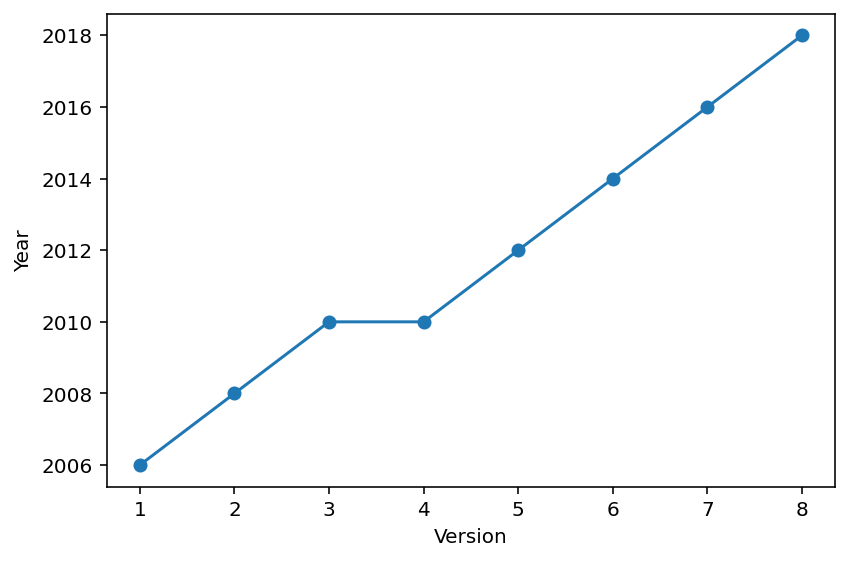

In [6]:
# Show the year number as a function of the version.
versions = data[['version', 'year']].drop_duplicates()
fig, ax = plt.subplots()
ax.plot(versions.version, versions.year, marker='o')
ax.set_xlabel('Version')
ax.set_ylabel('Year')
fig.tight_layout()

In [7]:
# Check that all data are the same in versions 3 and 4.
versions = [3, 4]
subsets = [data[data.version == version]
               .drop('version', axis=1)
               .sort_values('uwwCode')
               .reset_index(drop=True)
           for version in versions]
x, y = subsets
fltr = ((x == y) | (x.isnull() & y.isnull())).all(axis=1)
assert all(fltr)

# Then drop version 3.
cleaned = data[data.version != 3].copy()

# Fix a data error for Davyhulme that's got an order of magnitude error because there's an extra 1 prefixed.
cleaned.loc[cleaned.uwwCode == 'UKENNW_UU_TP000042', 'uwwCapacity'] = np.minimum(
    1206250, cleaned.loc[cleaned.uwwCode == 'UKENNW_UU_TP000042', 'uwwCapacity']
)

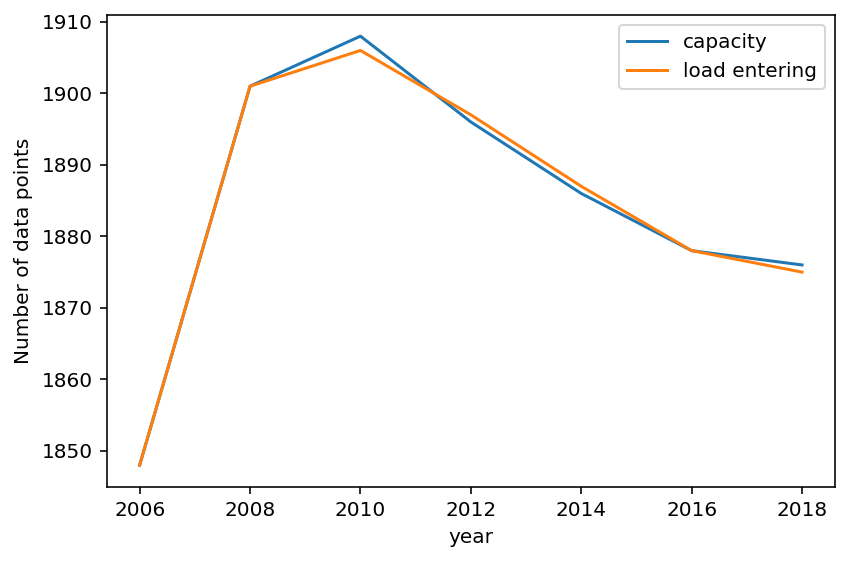

In [8]:
# Show number of data points over time.
counts = cleaned.groupby('year').count()
fig, ax = plt.subplots()
ax.plot(counts.index, counts.uwwCapacity, label='capacity')
ax.plot(counts.index, counts.uwwLoadEnteringUWWTP, label='load entering')
ax.legend()
ax.set_ylabel('Number of data points')
ax.set_xlabel(counts.index.name)
fig.tight_layout()

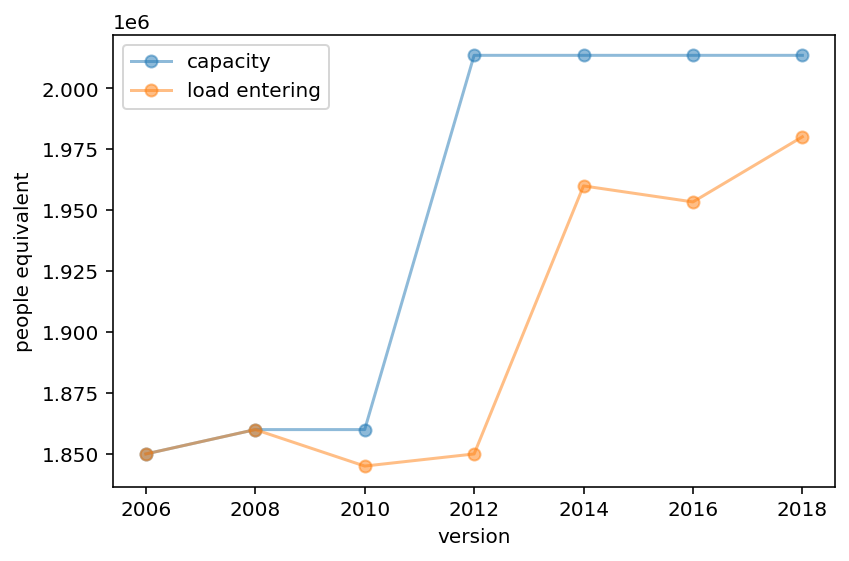

In [9]:
# Show capacity and load for Mogden.
code = 'UKENTH_TWU_TP000113'
subset = cleaned[cleaned.uwwCode == code]
kwargs = {
    'marker': 'o',
    'alpha': 0.5,
}

fig, ax = plt.subplots()
ax.plot(subset.year, subset.uwwCapacity, label='capacity', **kwargs)
ax.plot(subset.year, subset.uwwLoadEnteringUWWTP, label='load entering', **kwargs)
ax.set_xlabel('version')
ax.set_ylabel('people equivalent')
ax.legend()
fig.tight_layout()

In [14]:
# Save the data.
cleaned.to_csv('data/waterbase_consolidated.csv', index=False)

(1990, 7)

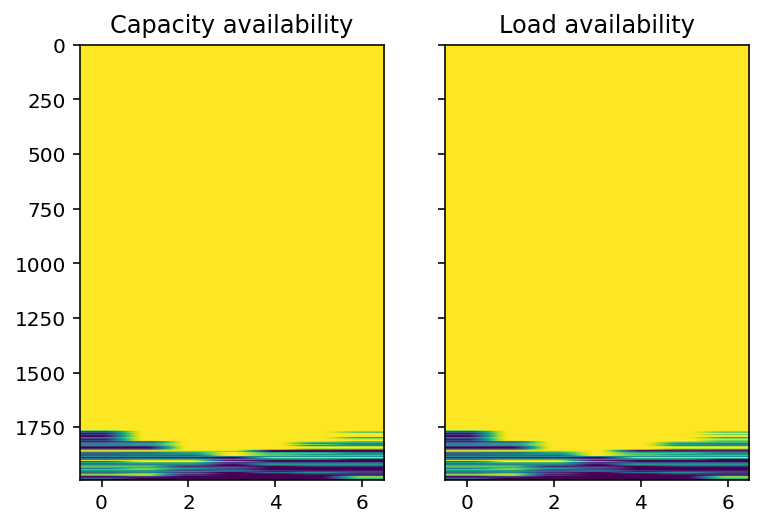

In [11]:
# Show availability of treatmentworks over time.
capacityAvailability = cleaned.set_index(['uwwCode', 'year']).uwwCapacity.unstack()
loadAvailability = cleaned.set_index(['uwwCode', 'year']).uwwLoadEnteringUWWTP.unstack()
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
kwargs = {
    'aspect': 'auto',
}
idx = np.argsort(loadAvailability.isnull().sum(axis=1))
ax1.imshow(~capacityAvailability.isnull().values[idx], **kwargs)
ax2.imshow(~loadAvailability.isnull().values[idx], **kwargs)
ax1.set_title('Capacity availability')
ax2.set_title('Load availability')
loadAvailability.shape

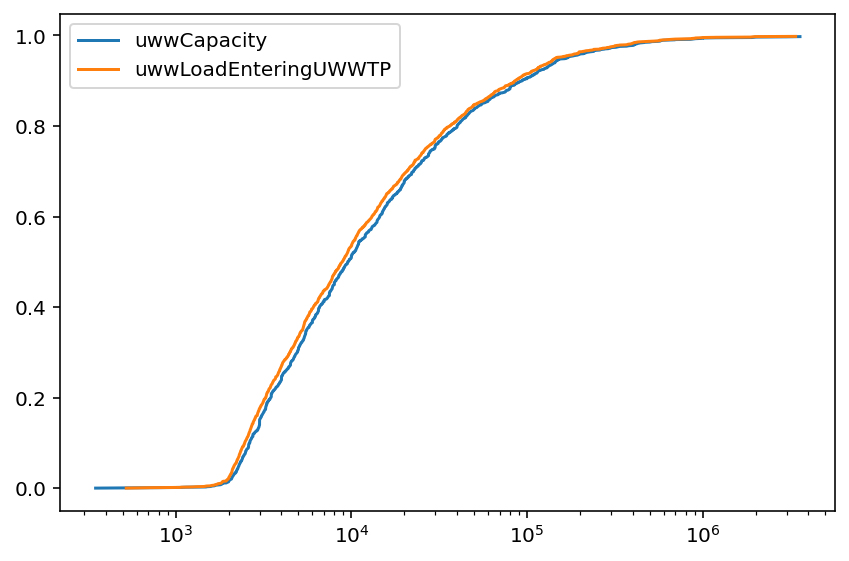

In [12]:
# Show the cumulative distribution function of treatment work capacities.
fig, ax = plt.subplots()
for key in ['uwwCapacity', 'uwwLoadEnteringUWWTP']:
    values = cleaned.groupby('uwwCode')[key].max().sort_values()
    ax.plot(values, (np.arange(len(values)) + 1) / len(values), label=key)
ax.set_xscale('log')
ax.legend()
fig.tight_layout()

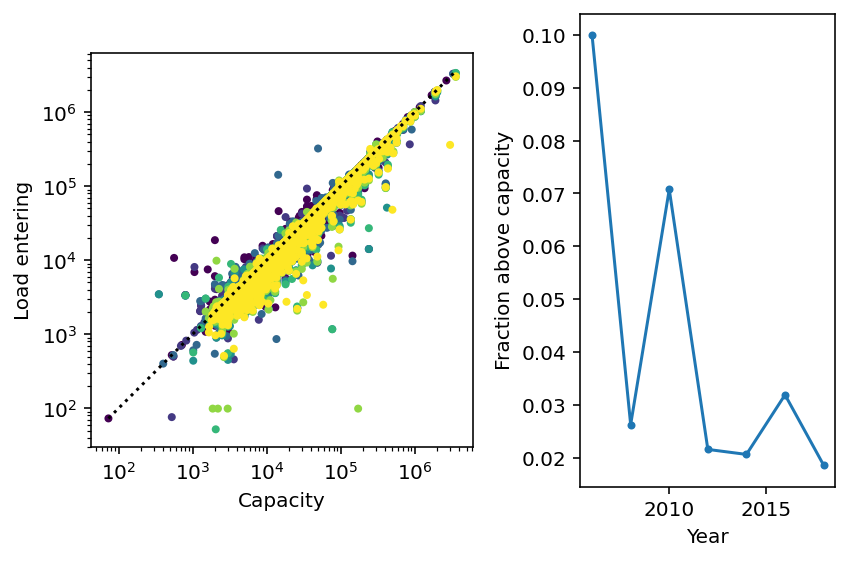

In [13]:
# Show the scatter of capacity and load coloured by year.
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 2]})
ax = ax1
fltr = (cleaned.uwwCapacity > 0) & (cleaned.uwwLoadEnteringUWWTP > 0)
subset = cleaned[fltr]
mm = subset.uwwCapacity.min(), subset.uwwCapacity.max()
ax.scatter(subset.uwwCapacity, subset.uwwLoadEnteringUWWTP, c=subset.year, marker='.')
ax.plot(mm, mm, color='k', ls=':')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_aspect('equal')
ax.set_xlabel('Capacity')
ax.set_ylabel('Load entering')

above_capacity = cleaned.groupby('year').apply(lambda x: (x.uwwLoadEnteringUWWTP > x.uwwCapacity).mean())
ax = ax2
ax.plot(above_capacity.index, above_capacity, marker='.')
ax.set_ylabel('Fraction above capacity')
ax.set_xlabel('Year')
fig.tight_layout()